In [3]:

import requests,pymysql,re,datetime
import pandas as pd
from sqlalchemy import create_engine
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns  #画图用的
import tushare as ts
token='ae7603bac9c9fd3f78f08f0e5f92ec9222c62f488e9e5a28c5002109'
pro = ts.pro_api(token)
%matplotlib inline

# 连接MySQL数据库
def connect_to_mysql(host,user,password,dbname):
    return pymysql.connect(host=host, user=user, password=password, database=dbname)

# 获取股票代码列表
def get_stock_codes():
    all_stock_codes = []
# URLs of the Wikipedia pages for SZSE and SSE listed companies
    urls = [
        "https://zh.wikipedia.org/wiki/深圳证券交易所主板上市公司列表",
        "https://zh.wikipedia.org/wiki/上海证券交易所主板上市公司列表"
    ]
    for i in range(len(urls)):
        url = urls[i]
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        tables = soup.find_all('table', {'class': 'wikitable'})

        for table in tables:
            for row in table.find_all('tr')[1:]:  # Skip header row
                cells = row.find_all('td')
                if cells:
                    if i == 0:
                    # Adjust index based on the actual table structure
                        stock_code = cells[i].text.strip()+'.SZ'  # Assuming code is in the first column
                    elif i == 1:
                         stock_code = cells[i].text.strip()+".SH"  # Assuming code is in the second column
                    all_stock_codes.append(stock_code)

    return all_stock_codes
def get_index_data(stock_code,start_date,end_date):
    # 初始化一个空的DataFrame，用于存储所有股票的收盘价数据
    data = pro.daily(ts_code=stock_code, start_date=start_date, end_date=end_date)
    data.sort_index(inplace=True)
    data = data[::-1]
    return data.reset_index(drop = True)

# 将股票历史行情数据插入到数据库中
def insert_to_database(data, code, cursor):
    try:
        code = f"{code.replace('.', '_')}"
        list_of_tuples = [tuple(row) for row in data.to_records(index=False)]

        print(list_of_tuples[0])
        # Ensure that the number of placeholders matches the number of values in the INSERT statement
        cursor.executemany(f"INSERT INTO s_{code} (stockName, dateTime, startPrice, maxPrice, minPrice, endPrice, lastDayEndPrice, diffPrice, diffPercent, turnoverAmount, amount) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",list_of_tuples)
        print(f"Data inserted successfully for {code}.")
    except Exception as e:
        print(f"Error inserting data for {code}: {e}")


#CreateDatabase(host,user,password,dbname)函数，创建本地数据库STOCK
#创建数据库用于存储股票数据表
def CreateDatabase(host,user,password,dbname):
    try:
        db = pymysql.connect(host=host, user=user, password=password, port=3306)
        cursor = db.cursor()
        cursor.execute('CREATE DATABASE IF NOT EXISTS ' + dbname)
        print(f'Database "{dbname}" checked/created successfully.')
    except Exception as e:
        print(f"Failed to create/check database '{dbname}'. Error: {e}")
    finally:
        if db:
            db.close()



#CreateTable(host,user,password,dbname,codeList) 函数，根据股票代码 为每只股票创建、添加数据表
#根据股票代码，创建添加股票数据表，用于存储每只股票数据，table:s_600001
def CreateTable(host, user, password, dbname, codeList):
    try:
        db = pymysql.connect(host=host, user=user, password=password, database=dbname)
        cursor = db.cursor()
        for code in codeList:
            table_name = f"{code.replace('.', '_')}"  # Replace periods with underscores
            sql = f'''CREATE TABLE IF NOT EXISTS {table_name} (
                stockName VARCHAR(250) NOT NULL,
                dateTime VARCHAR(250) NOT NULL,
                startPrice VARCHAR(100),
                maxPrice VARCHAR(100),
                minPrice VARCHAR(100),
                endPrice VARCHAR(100),
                lastDayEndPrice VARCHAR(100),
                diffPrice VARCHAR(100),
                diffPercent VARCHAR(100),
                turnoverAmount VARCHAR(100),
                amount VARCHAR(100)
            )'''
            cursor.execute(sql)
            print(f'Table "{table_name}" checked/created successfully.')
    except Exception as e:
        print(f"Failed to create/check table. Error: {e}")
    finally:
        if db:
            db.close()
#retrieve stock information based on stock code
def retrieve_stock_info(host, user, password, dbname, stock_code):
    try:
        # Connect to the MySQL database
        db = pymysql.connect(host=host, user=user, password=password, database=dbname)
        cursor = db.cursor(pymysql.cursors.DictCursor)  # Use DictCursor to get data as dictionaries

        # Format the table name correctly (assuming stock codes are formatted as s_XXXXXX)
        table_name = f"s_{stock_code.replace('.', '_')}"

        # Execute a SELECT query to retrieve all data from the specified table
        sql = f"SELECT * FROM {table_name}"
        cursor.execute(sql)

        # Fetch all rows from the last executed query
        result = cursor.fetchall()

        # Optionally, convert the result to a pandas DataFrame for easier handling
        df = pd.DataFrame(result)

        # Close the database connection
        db.close()

        return df
    except Exception as e:
        print(f"Error retrieving data for stock {stock_code}: {e}")
        return None

def deleteTable(host, user, password, dbname, codeList):
    # Connect to the database
    conn = pymysql.connect(host=host, user=user, password=password, database=dbname)
    cur = conn.cursor()

    try:
        for code in codeList:
            table_name = f"s_{code.replace('.', '_')}"
            # SQL statement to drop a table
            sql = f"DROP TABLE IF EXISTS {table_name};"
            cur.execute(sql)

        conn.commit()  # Commit the transaction
        print("Tables successfully deleted.")
    except Exception as e:
        print(f"An error occurred: {e}")
        conn.rollback()  # Rollback in case of any error
    finally:
        cur.close()
        conn.close()


host = "localhost"
user = "root"
password = "Ch214199"
dbname = "Week3"

try:
    db = connect_to_mysql(host, user, password, dbname)
    print("Database connection established successfully.")
except Exception as e:
    print(f"Failed to connect to database. Error: {e}")
    exit()  # Exit the script if the connection fails


Database connection established successfully.


In [4]:
cursor = db.cursor()
all_stocks = get_stock_codes()
all_stocks = [item for item in all_stocks if item.split(".")[0].isdigit()]

CreateDatabase(host,user,password,dbname)
CreateTable(host,user,password,dbname,all_stocks)


# 获取历史数据并插入数据库
for code in all_stocks:
    try:
        history_data = get_index_data(code, '20200101', datetime.now().strftime('%Y%m%d'))
        insert_to_database(history_data[1:],code, cursor)  # 第一行是表头，跳过
        db.commit()
        print(f"Inserted data for {code}")
    except Exception as e:
        print(f"Error inserting data for {code}: {e}")
        db.rollback()

# 关闭数据库连接
db.close()


Database "Week3" checked/created successfully.
Table "000001_SZ" checked/created successfully.
Table "000002_SZ" checked/created successfully.
Table "000004_SZ" checked/created successfully.
Table "000005_SZ" checked/created successfully.
Table "000006_SZ" checked/created successfully.
Table "000007_SZ" checked/created successfully.
Table "000008_SZ" checked/created successfully.
Table "000009_SZ" checked/created successfully.
Table "000010_SZ" checked/created successfully.
Table "000011_SZ" checked/created successfully.
Table "000012_SZ" checked/created successfully.
Table "000014_SZ" checked/created successfully.
Table "000016_SZ" checked/created successfully.
Table "000017_SZ" checked/created successfully.
Table "000019_SZ" checked/created successfully.
Table "000020_SZ" checked/created successfully.
Table "000021_SZ" checked/created successfully.
Table "000023_SZ" checked/created successfully.
Table "000025_SZ" checked/created successfully.
Table "000026_SZ" checked/created success

KeyboardInterrupt: 

Task 2

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_14134/3914722161.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_log.loc[:,'Profit/Loss'] = 100 * df['DailyReturn']


For stock 000001.SZ
Total Return: 56.51%
Max Drawdown: -43.07%


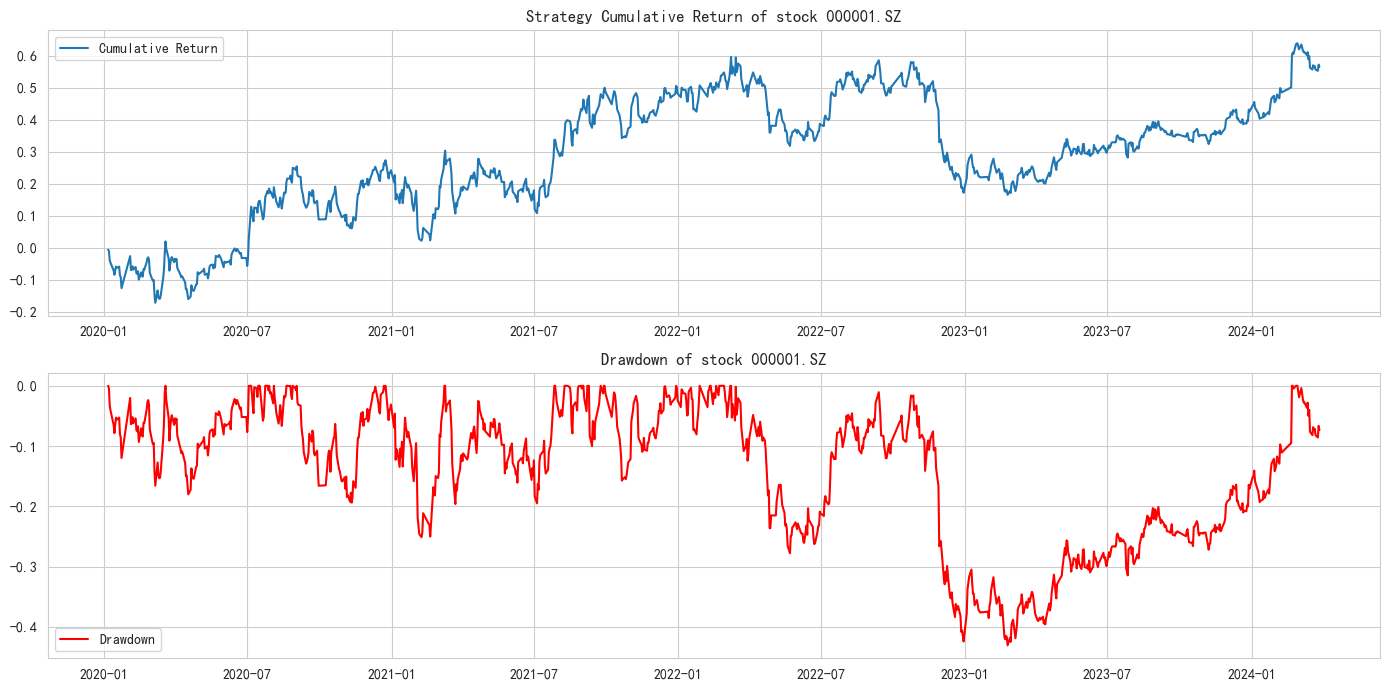

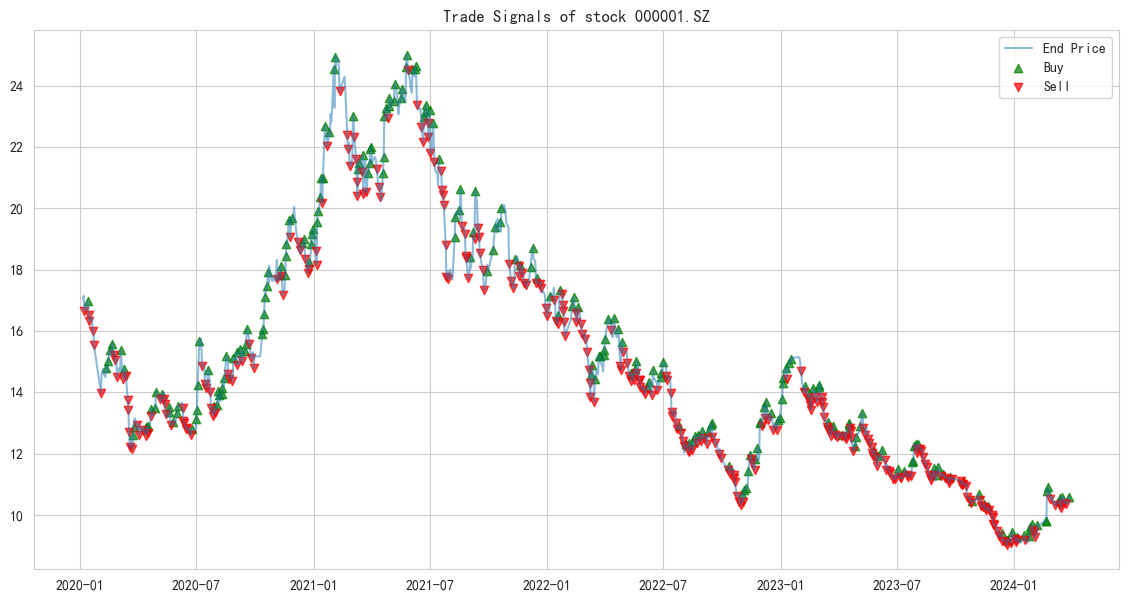

In [19]:
df = retrieve_stock_info(host, user, password, dbname, "000001.SZ")
def momental_strategy(df):
    df.iloc[:,2:] = df.iloc[:,2:].astype(float)
    df['Position'] = np.where(df['endPrice'] > df['lastDayEndPrice'], 1, -1)

    df['TradeAmount'] = 1 * df['endPrice']
    df['DailyReturn'] = \
        df['Position'].shift(1) * (df['endPrice'] - df['endPrice'].shift(1)) / df['endPrice'].shift(1)
    df['CumulativeReturn'] = df['DailyReturn'].cumsum()



    return df
#momental_strategy(df)

In [21]:
df

SyntaxError: invalid syntax (1836031960.py, line 1)

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_14134/3914722161.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_log.loc[:,'Profit/Loss'] = 100 * df['DailyReturn']


For stock 000001.SZ
Total Return: 56.51%
Max Drawdown: -43.07%


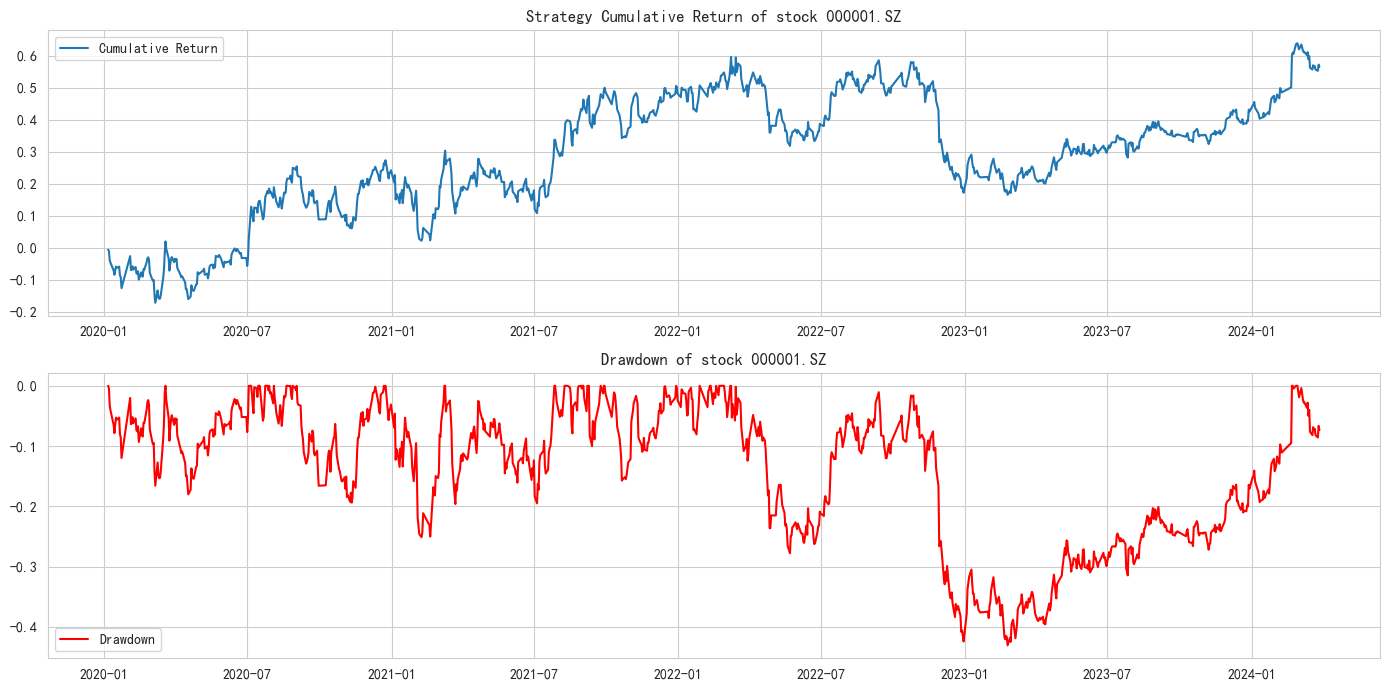

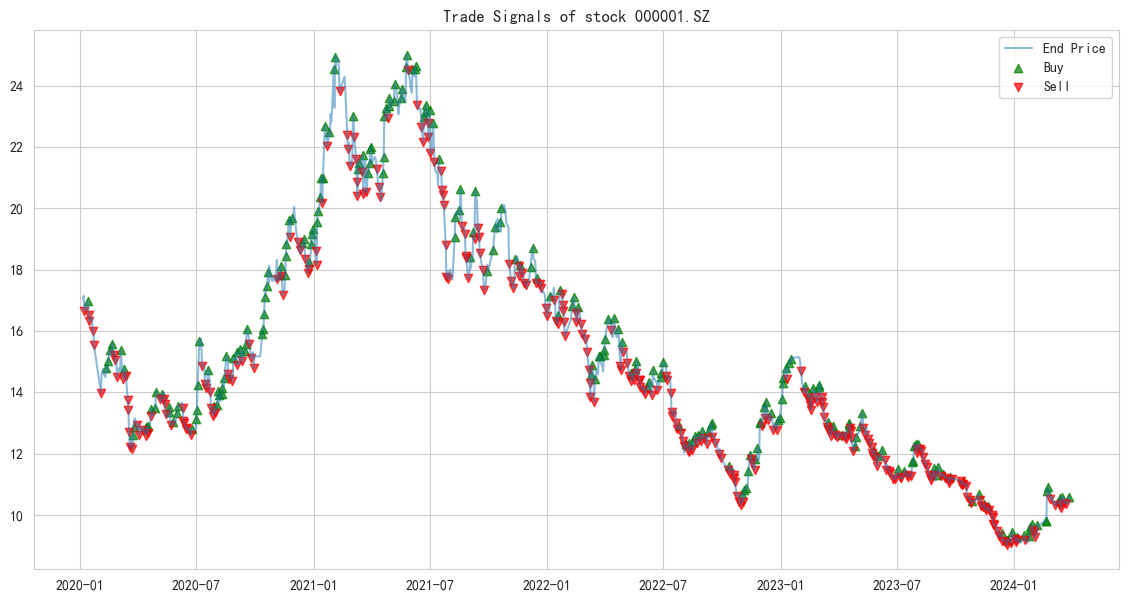

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_14134/3914722161.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_log.loc[:,'Profit/Loss'] = 100 * df['DailyReturn']


For stock 000002.SZ
Total Return: -15.85%
Max Drawdown: -89.84%


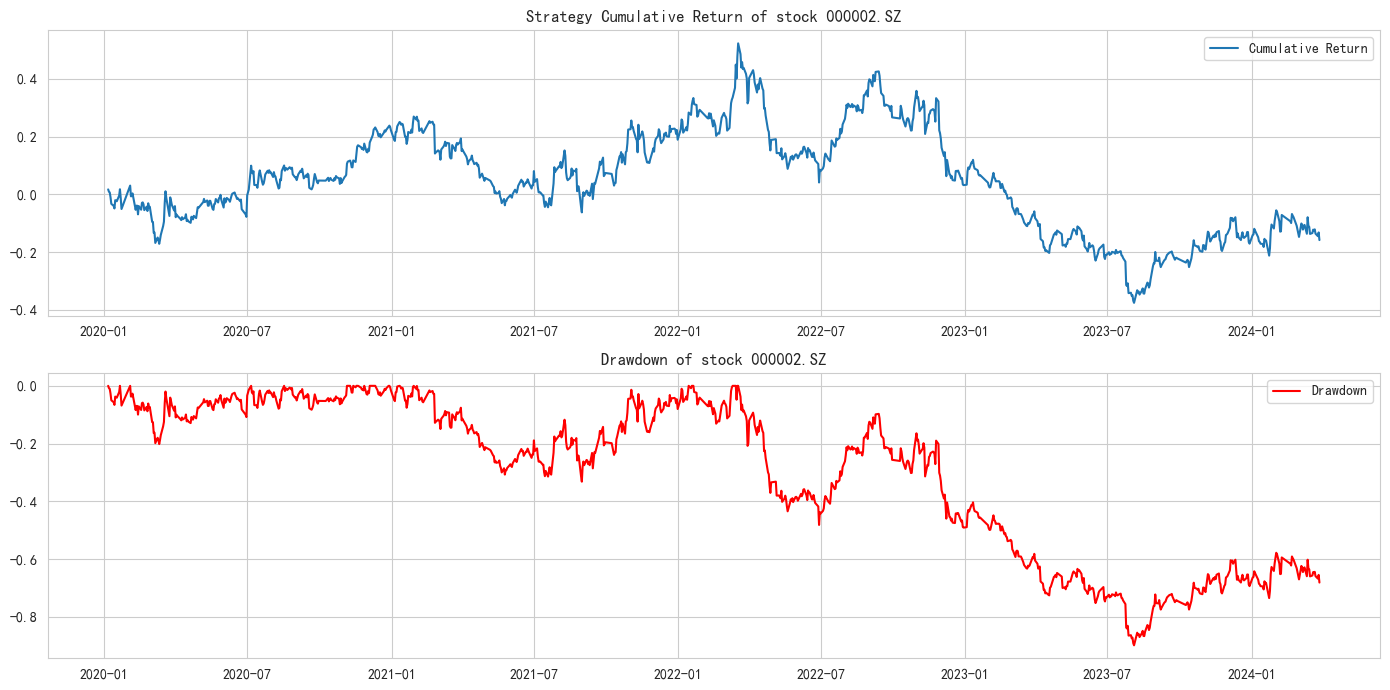

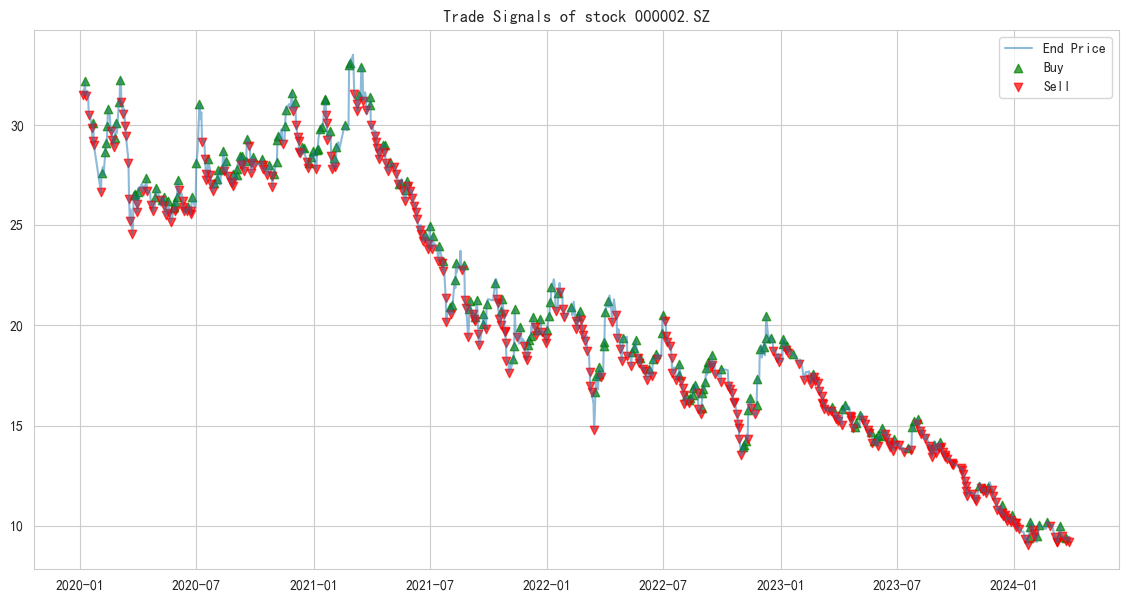

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_14134/3914722161.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_log.loc[:,'Profit/Loss'] = 100 * df['DailyReturn']


For stock 000004.SZ
Total Return: 155.63%
Max Drawdown: -79.73%


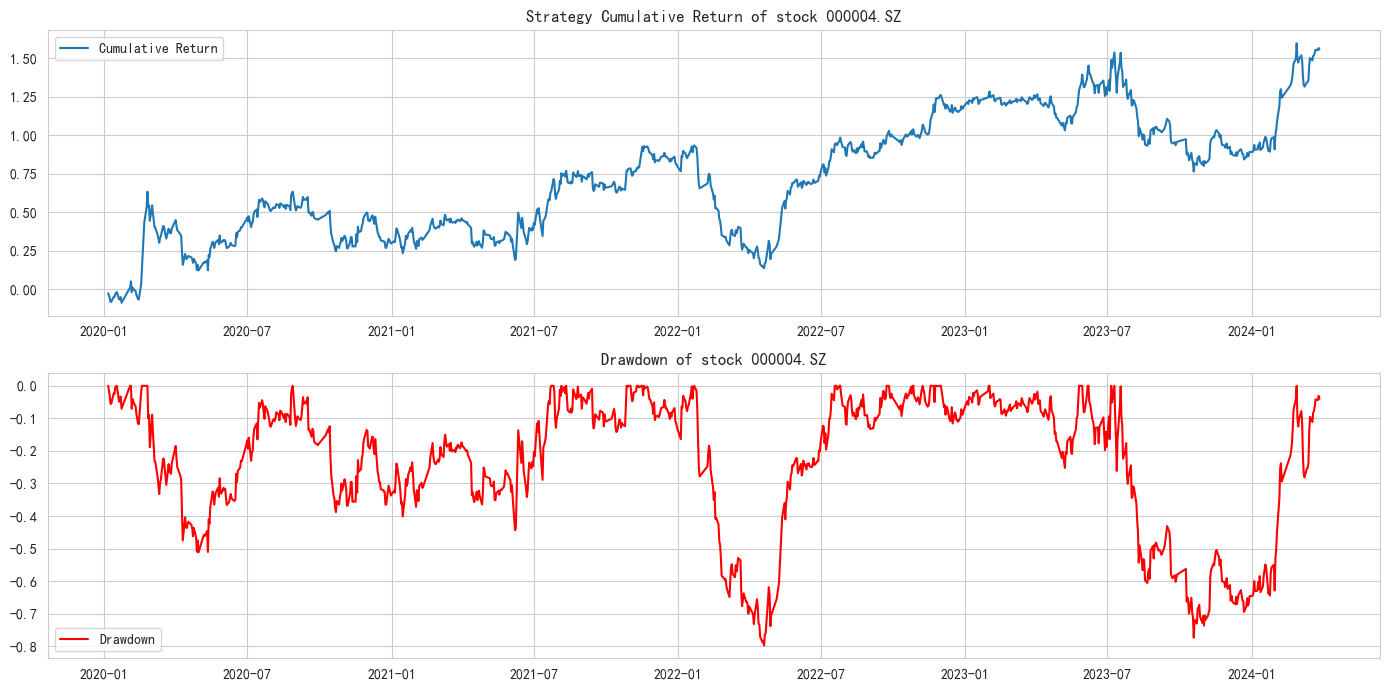

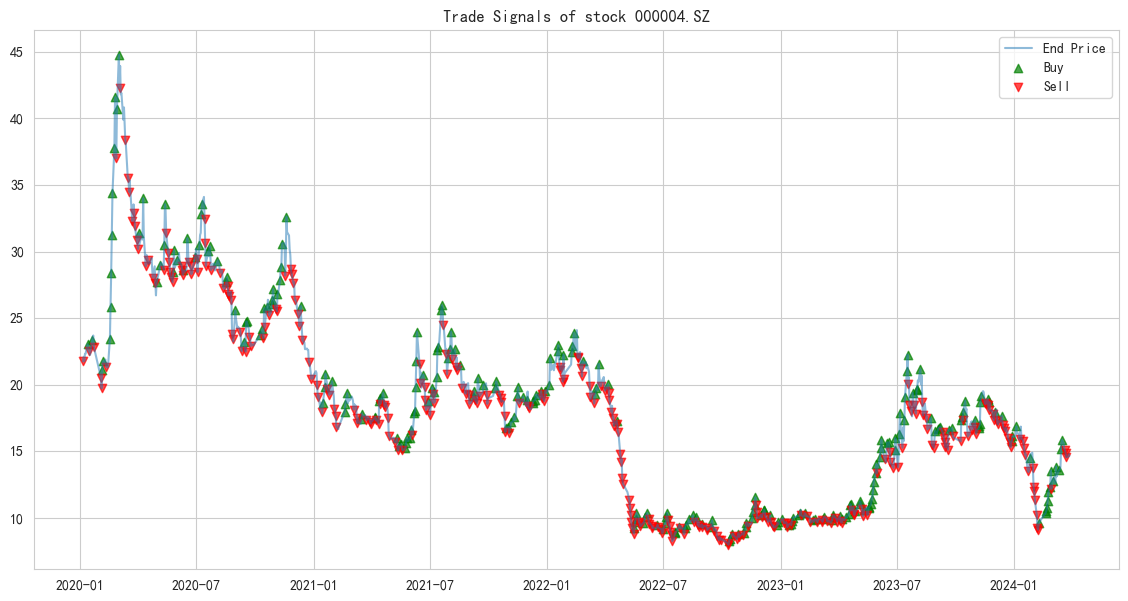

In [22]:
get_index_data("000001.SZ", '20200101', datetime.now().strftime('%Y%m%d'))

0.6542696979545762